In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
train_data = pd.read_csv('drive/My Drive/MNIST/train.csv')
test_data  = pd.read_csv('drive/My Drive/MNIST/test.csv')
sample     = pd.read_csv('drive/My Drive/MNIST/sample_submission.csv')
train_data.shape, test_data.shape

((42000, 785), (28000, 784))

In [0]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [9]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train, val = train_test_split(train_data, test_size = 0.2)
train_x = train.drop('label', axis = 1)
train_y = train['label']
val_x   = val.drop('label', axis = 1)
val_y   = val['label']
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((33600, 784), (33600,), (8400, 784), (8400,))

Each data point consists of 784 values. A fully connected net just treats all these values the same, but a CNN treats it as a 28x28 square. Thes two graphs explain the difference: It's easy to understand why a CNN can get better results.

Text(0.5, 1.0, '28x28 data')

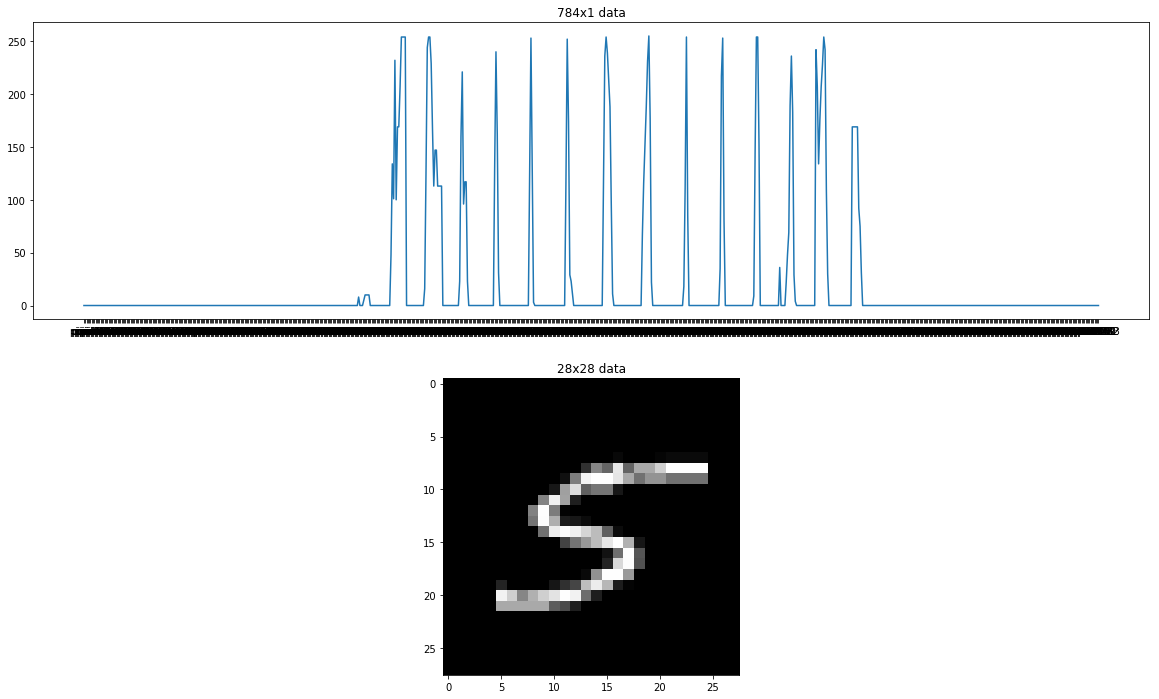

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(20,12))
ax[0].plot(train_x.iloc[11,0:])
ax[0].set_title('784x1 data')
ax[1].imshow(train_x.iloc[11,0:].values.reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

We now reshape all data this way. Keras wants an extra dimension in the end, for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses one.

This notebook is written for the tensorflow channel ordering. If you have Keras installed for Theano backend, you might start seeing some error message soon related to channel ordering. This can easily be solved.

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = train_x.values.reshape(-1, 28, 28, 1)
x_val   = val_x.values.reshape(-1, 28, 28, 1)

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster.

In [0]:
x_train = x_train.astype("float32")/255.
x_val   = x_val.astype("float32")/255.

In [24]:
x_train.shape

(33600, 28, 28, 1)

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [13]:
y_train = to_categorical(train_y)
y_val   = to_categorical(val_y)
#example:
print(y_train[11])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Train the model
Keras offers two different ways of defining a network. We will the Sequential API, where you just add on one layer at a time, starting from the input.

The most important part are the convolutional layers Conv2D. Here they have 16-32 filters that use nine weights each to transform a pixel to a weighted average of itself and its eight neighbors. As the same nine weights are used over the whole image, the net will pick up features that are useful everywhere. As it is only nine weights, we can stack many convolutional layers on top of each other without running out of memory/time.

The MaxPooling layers just look at four neighboring pixels and picks the maximal value. This reduces the size of the image by half, and by combining convolutional and pooling layers, the net be able to combine its features to learn more global features of the image. In the end we use the features in two fully-connected (Dense) layers.

Batch Normalization is a technical trick to make training faster. Dropout is a regularization method, where the layer randomly replaces a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization. 'relu' is the activation function x -> max(x,0)

In [0]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Another important method to improve generalization is augmentation. This means generating more training data by randomly perturbing the images. If done in the right way, it can force the net to only learn translation-invariant features. If you train this model over hundreds of epochs, augmentation will definitely improve your performance. Here in the Kernel, we will only look at each image 4-5 times, so the difference is smaller. We use a Keras function for augmentation.

In [0]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this:

In [0]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

We will use a very small validation set during training to save time in the kernel.

In [92]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=40, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/40
 - 37s - loss: 0.8967 - acc: 0.7188 - val_loss: 0.1516 - val_acc: 0.9425
Epoch 2/40
 - 32s - loss: 0.3468 - acc: 0.8950 - val_loss: 0.1147 - val_acc: 0.9625
Epoch 3/40
 - 32s - loss: 0.2519 - acc: 0.9239 - val_loss: 0.0972 - val_acc: 0.9725
Epoch 4/40
 - 33s - loss: 0.2225 - acc: 0.9369 - val_loss: 0.0848 - val_acc: 0.9675
Epoch 5/40
 - 32s - loss: 0.1823 - acc: 0.9473 - val_loss: 0.0695 - val_acc: 0.9750
Epoch 6/40
 - 32s - loss: 0.1614 - acc: 0.9546 - val_loss: 0.0415 - val_acc: 0.9900
Epoch 7/40
 - 32s - loss: 0.1431 - acc: 0.9583 - val_loss: 0.0490 - val_acc: 0.9850
Epoch 8/40
 - 32s - loss: 0.1445 - acc: 0.9576 - val_loss: 0.0526 - val_acc: 0.9825
Epoch 9/40
 - 32s - loss: 0.1307 - acc: 0.9605 - val_loss: 0.0339 - val_acc: 0.9875
Epoch 10/40
 - 32s - loss: 0.1208 - acc: 0.9633 - val_loss: 0.0256 - val_acc: 0.9900
Epoch 11/40
 - 33s - loss: 0.1092 - acc: 0.9684 - val_loss: 0.0369 - val_acc: 0.9875
Epoch 12/40
 - 32s - loss: 0.1168 - acc: 0.9680 - val_loss: 0.0350 - val_a

In [93]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0189, final accuracy: 0.9943


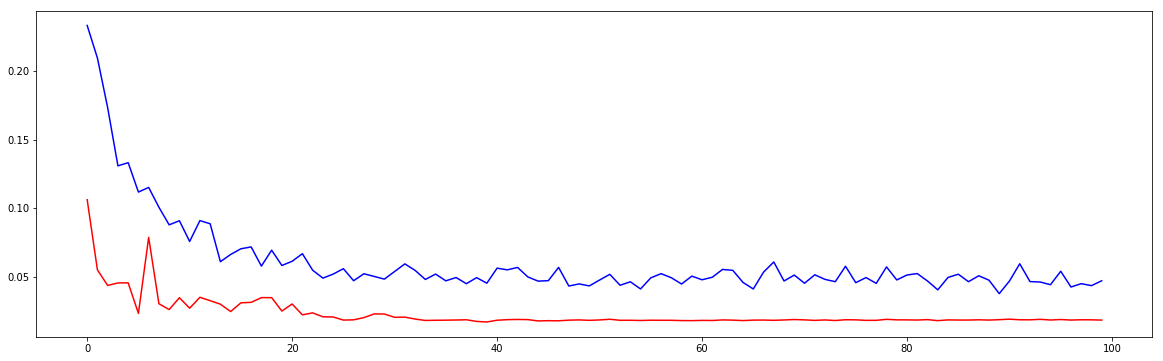

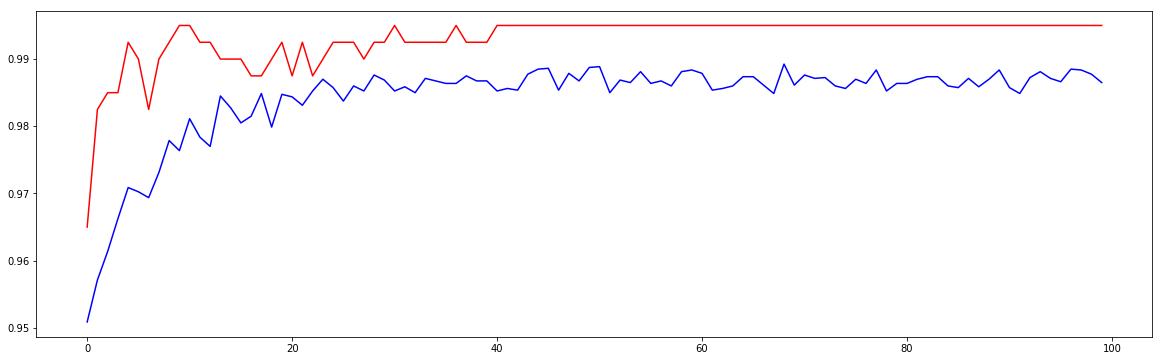

In [77]:
plt.figure(figsize = (20,6))
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.figure(figsize = (20,6))
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [78]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[804   0   0   0   1   0   3   0   0   0]
 [  0 898   1   0   0   0   1   2   1   0]
 [  1   0 855   0   0   0   0   2   0   0]
 [  0   0   1 886   0   2   0   1   2   0]
 [  0   0   0   0 814   0   0   0   0   3]
 [  0   0   0   0   0 773   1   0   2   1]
 [  1   0   0   0   0   0 833   0   1   0]
 [  0   0   0   1   0   0   0 873   0   0]
 [  0   0   0   1   0   0   1   0 842   1]
 [  0   0   0   1   2   0   0   1   0 787]]


In [0]:
x_test = test_data.astype("float32")
x_test = x_test.values.reshape(-1, 28, 28, 1)/255.

In [0]:
y_hat = model.predict(x_test, batch_size=64)

In [97]:
y_hat

array([[3.5977937e-12, 1.5901939e-11, 1.0000000e+00, ..., 2.6932552e-09,
        4.0716066e-11, 2.2517413e-13],
       [9.9999309e-01, 2.7299712e-10, 3.3586923e-07, ..., 1.0167949e-08,
        1.5846356e-06, 2.9894873e-06],
       [4.6238404e-09, 4.3328771e-11, 1.9511109e-08, ..., 3.3516224e-07,
        4.4166909e-06, 9.9996305e-01],
       ...,
       [1.6836035e-20, 3.7757427e-17, 5.0875907e-15, ..., 2.9260386e-17,
        5.5433809e-15, 1.5775697e-14],
       [3.4706628e-07, 1.0482472e-08, 1.1178186e-06, ..., 5.8128597e-05,
        3.7918812e-06, 9.9974495e-01],
       [6.2466644e-13, 3.9949780e-12, 1.0000000e+00, ..., 1.6837670e-09,
        2.1956430e-10, 7.5308640e-13]], dtype=float32)

y_hat consists of class probabilities (corresponding to the one-hot encoding of the training labels). I now select the class with highest probability

In [0]:
y_pred = np.argmax(y_hat,axis=1)

In [101]:
sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [105]:
sub_1 = pd.DataFrame({'ImageId' : sample['ImageId'],
                     'Label'    : y_pred})
sub_1.shape

(28000, 2)

In [0]:
sub_1.to_csv('drive/My Drive/MNIST/sub_1_CNN_MNIST.csv', index = False)

# NCREASING DATA AUGMENTATION

In [0]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=["accuracy"])
#with adam 99.42

In [0]:
annealer = learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [42]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs= 300, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/300
 - 5s - loss: 0.1546 - acc: 0.9749 - val_loss: 0.0289 - val_acc: 0.9900
Epoch 2/300
 - 5s - loss: 0.1538 - acc: 0.9744 - val_loss: 0.0456 - val_acc: 0.9875
Epoch 3/300
 - 5s - loss: 0.1899 - acc: 0.9726 - val_loss: 0.0320 - val_acc: 0.9925
Epoch 4/300
 - 5s - loss: 0.1736 - acc: 0.9705 - val_loss: 0.0355 - val_acc: 0.9925
Epoch 5/300
 - 5s - loss: 0.1747 - acc: 0.9730 - val_loss: 0.0266 - val_acc: 0.9950
Epoch 6/300
 - 5s - loss: 0.1647 - acc: 0.9705 - val_loss: 0.0392 - val_acc: 0.9925
Epoch 7/300
 - 5s - loss: 0.1704 - acc: 0.9745 - val_loss: 0.0400 - val_acc: 0.9950
Epoch 8/300
 - 5s - loss: 0.1803 - acc: 0.9718 - val_loss: 0.0345 - val_acc: 0.9950

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00011249999806750566.
Epoch 9/300
 - 5s - loss: 0.1374 - acc: 0.9754 - val_loss: 0.0434 - val_acc: 0.9950
Epoch 10/300
 - 5s - loss: 0.1655 - acc: 0.9753 - val_loss: 0.0292 - val_acc: 0.9950
Epoch 11/300
 - 5s - loss: 0.1614 - acc: 0.9720 - val_loss: 0.0169 - val_acc:

In [43]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose = 0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0275, final accuracy: 0.9943


# Second Model

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.



In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [0]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# CNN BAGGED

In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
#99.74

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [0]:
Y_train  = train_data["label"]
X_train  = train_data.drop(["label"],axis = 1)
X_train  = X_train / 255.0
X_test   = test_data / 255.0
X_train  = X_train.values.reshape(-1,28,28,1)
X_test   = X_test.values.reshape(-1,28,28,1)
Y_train  = to_categorical(Y_train, num_classes = 10)

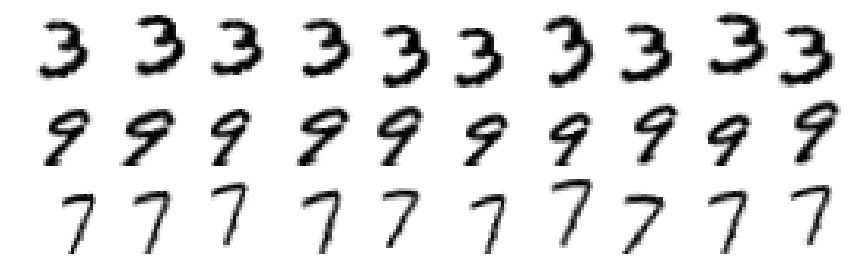

In [8]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [0]:
nets = 10
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=45, Train accuracy=0.99587, Validation accuracy=0.99643
CNN 2: Epochs=45, Train accuracy=0.99605, Validation accuracy=0.99524
CNN 3: Epochs=45, Train accuracy=0.99637, Validation accuracy=0.99500
CNN 4: Epochs=45, Train accuracy=0.99616, Validation accuracy=0.99667
CNN 5: Epochs=45, Train accuracy=0.99650, Validation accuracy=0.99333
CNN 6: Epochs=45, Train accuracy=0.99621, Validation accuracy=0.99619
CNN 7: Epochs=45, Train accuracy=0.99656, Validation accuracy=0.99571
CNN 8: Epochs=45, Train accuracy=0.99618, Validation accuracy=0.99786
CNN 9: Epochs=45, Train accuracy=0.99642, Validation accuracy=0.99548
CNN 10: Epochs=45, Train accuracy=0.99613, Validation accuracy=0.99595


In [0]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv('drive/My Drive/MNIST/sub_2_CNN_MNIST_BAGGED_20_bagged.csv',index=False)

#99.75 result. top 200
